In [1]:
import pandas as pd # standard python data library
import geopandas as gp # the geo-version of pandas
import numpy as np 
import os
import fiona
from statistics import mean, median
from pandas import read_csv
gp.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw' #To load KML files
import string
import xml.etree.ElementTree as et

# Maryland

## VEST Documentation

Election results from Maryland State Board of Elections (https://elections.maryland.gov/elections/2018/election_data/index.html)  
Precinct shapefile from Maryland Department of Planning

Early, Provisional, and Absentee votes are reported only at the county level. These votes are apportioned to precincts by candidate in the same shares that the Election Day vote was split among precincts within a county.

G18GOVRHOG - Larry Hogan (Republican Party)  
G18GOVDJEA - Ben Jealous (Democratic Party)  
G18GOVLQUI - Shawn Quinn (Libertarian Party)  
G18GOVGSCH - Ian Schlakman (Green Party)  
G18GOVOWRI - Write-in Votes  

G18COMRPHU - Anjali Reed Phukan (Republican Party)  
G18COMDFRA - Peter Franchot (Democratic Party)  
G18COMOWRI - Write-in Votes  

G18ATGRWOL - Craig Wolf (Republican Party)  
G18ATGDFRO - Brian E. Frosh (Democratic Party)  
G18ATGOWRI - Write-in Votes  

G18USSRCAM - Tony Campbell (Republican Party)  
G18USSDCAR - Ben Cardin (Democratic Party)  
G18USSLVOH - Arvin Vohra (Libertarian Party)  
G18USSISIM - Neal Simon (Unaffiliated)  
G18USSOWRI - Write-in Votes  

In [2]:
vest_md_18 = gp.read_file("./raw-from-source/VEST/md_2018/md_2018.shp")

In [3]:
source_elections = pd.read_csv("./raw-from-source/Election_Results/All_By_Precinct_2018_General.csv")

/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
print(source_elections)

        County  Election District  Election Precinct  Cong Legs  \
0            1                  1                  0     6  01C   
1            1                  1                  0     6  01C   
2            1                  1                  0     6  01C   
3            1                  1                  0     6  01C   
4            1                  1                  0     6  01C   
...        ...                ...                ...   ...  ...   
132655      24                  7                  1     1  38C   
132656      24                  7                  1     1  38C   
132657      24                  7                  1     1  38C   
132658      24                  7                  1     1  38C   
132659      24                  7                  1     1  38C   

         Candidate Name Party              Office Name Office District Winner  \
0           Larry Hogan   REP  Governor / Lt. Governor             NaN      Y   
1           Ben Jealous   DEM  Go

In [5]:
md_pct = gp.read_file("/Users/peterhorton/Downloads/precinct2010/Precinct2010_83NadMeters.shp")

<AxesSubplot:>

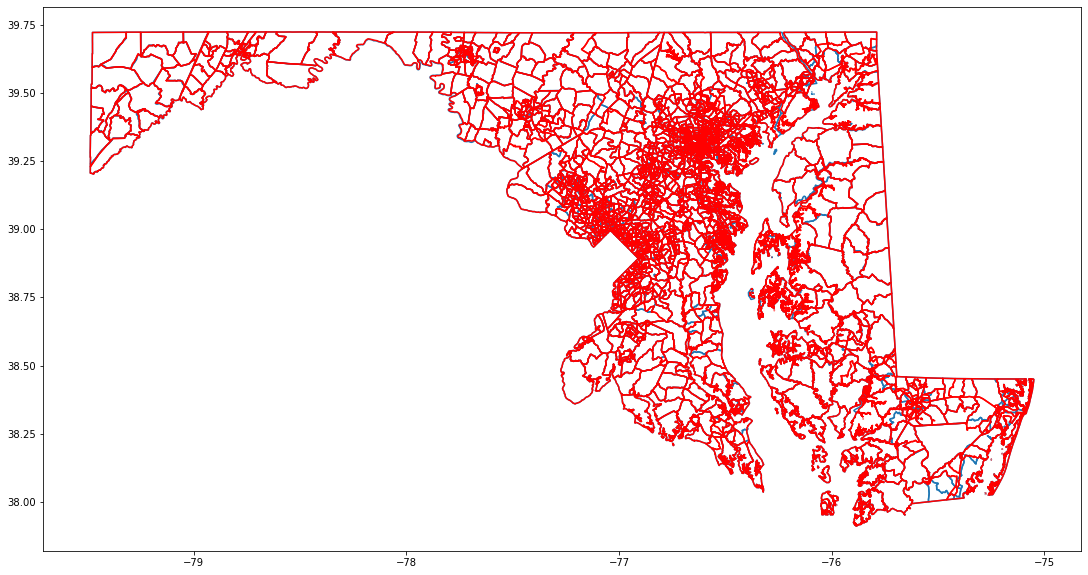

In [6]:
md_pct = md_pct.to_crs(vest_md_18.crs)


ax = md_pct.boundary.plot(figsize=(20,10))
vest_md_18.boundary.plot(color='red',ax=ax)

In [7]:
source_elections["Office Name"] = source_elections["Office Name"].str.strip()


In [8]:
source_elections["Office Name"].unique()

array(['Governor / Lt. Governor', 'Comptroller', 'Attorney General',
       'U.S. Senator', 'Representative in Congress', 'State Senator',
       'House of Delegates', 'County Commissioner',
       'Judge Court of Appeals', 'Judge Special Appeals At Large',
       "State's Attorney", 'Clerk Circuit Court', 'Register of Wills',
       'Judge Orphans Court', 'Sheriff', 'Board of Education',
       'Mayor of Cumberland', 'Council - City of Cumberland',
       'County Executive', 'County Council', 'Judge of the Circuit Court',
       'Cty Commission at Large', 'Treasurer',
       'Board of Education At Large', 'Pres County Commission',
       'County Council At Large', 'Pres County Council',
       'Judge Special Appeals'], dtype=object)

In [9]:
sorted(vest_md_18["JURSCODE"].unique())

['ALLE',
 'ANNE',
 'BACI',
 'BACO',
 'CALV',
 'CARO',
 'CARR',
 'CECI',
 'CHAR',
 'DORC',
 'FRED',
 'GARR',
 'HARF',
 'HOWA',
 'KENT',
 'MONT',
 'PRIN',
 'QUEE',
 'SOME',
 'STMA',
 'TALB',
 'WASH',
 'WICO',
 'WORC']

In [10]:
def swapPositions(list, pos1, pos2):
     
    list[pos1], list[pos2] = list[pos2], list[pos1]
    return list
 
# Driver function
List = [23, 65, 19, 90]
pos1, pos2  = 1, 3
 
juris_list = swapPositions(sorted(vest_md_18["JURSCODE"].unique()), 18, 19)

In [11]:
num_juris_dict = dict(zip(range(1,25),juris_list))
source_elections["County"] = source_elections["County"].map(num_juris_dict)

In [12]:
source_elections = source_elections[source_elections["Office Name"].isin(['Governor / Lt. Governor', 'Comptroller', 'Attorney General','U.S. Senator'])]
source_elections["Cand-Detailed"] = source_elections["Candidate Name"]+"-"+source_elections["Office Name"]
source_elections["pivot_col"] = source_elections["County"].astype(str)+"-"+source_elections["Election District"].astype(str)+"-"+source_elections["Election Precinct"].astype(str)
pivoted_results = pd.pivot_table(source_elections,index=["pivot_col"],columns=["Cand-Detailed"],values=['Election Night Votes'],aggfunc=sum)
pivoted_results = pivoted_results.fillna(0)
pivoted_results.columns = pivoted_results.columns.droplevel(0)
pivoted_results.reset_index(drop=False,inplace=True)

In [13]:
print(pivoted_results.columns)

Index(['pivot_col', 'Anjali Reed Phukan-Comptroller',
       'Arvin Vohra-U.S. Senator', 'Ben Cardin-U.S. Senator',
       'Ben Jealous-Governor / Lt. Governor',
       'Brian E. Frosh-Attorney General', 'Craig Wolf-Attorney General',
       'Edward Shlikas-U.S. Senator', 'Ian Schlakman-Governor / Lt. Governor',
       'Larry Hogan-Governor / Lt. Governor', 'Lih Young-U.S. Senator',
       'Michael B. Puskar-U.S. Senator', 'Neal Simon-U.S. Senator',
       'Other Write-Ins-Attorney General', 'Other Write-Ins-Comptroller',
       'Other Write-Ins-Governor / Lt. Governor',
       'Other Write-Ins-U.S. Senator', 'Peter Franchot-Comptroller',
       'Shawn Quinn-Governor / Lt. Governor', 'Tony Campbell-U.S. Senator'],
      dtype='object', name='Cand-Detailed')


In [14]:
col_rename_dict = {'pivot_col':'County-Dist-Prec',
    'Anjali Reed Phukan-Comptroller':"G18COMRPHU",
       'Arvin Vohra-U.S. Senator':"G18USSLVOH", 'Ben Cardin-U.S. Senator':"G18USSDCAR",
       'Ben Jealous-Governor / Lt. Governor':"G18GOVDJEA",
       'Brian E. Frosh-Attorney General':"G18ATGDFRO", 'Craig Wolf-Attorney General':"G18ATGRWOL",
       'Edward Shlikas-U.S. Senator':"G18USSOWRI_3", 'Ian Schlakman-Governor / Lt. Governor':"G18GOVGSCH",
       'Larry Hogan-Governor / Lt. Governor':"G18GOVRHOG", 'Lih Young-U.S. Senator':"G18USSOWRI_2",
       'Michael B. Puskar-U.S. Senator':"G18USSOWRI_1", 'Neal Simon-U.S. Senator':"G18USSISIM",
       'Other Write-Ins-Attorney General':"G18ATGOWRI",
        'Other Write-Ins-Comptroller':"G18COMOWRI",
       'Other Write-Ins-Governor / Lt. Governor':"G18GOVOWRI",
       'Other Write-Ins-U.S. Senator':"G18USSOWRI", 'Peter Franchot-Comptroller':"G18COMDFRA",
       'Shawn Quinn-Governor / Lt. Governor':"G18GOVLQUI", 'Tony Campbell-U.S. Senator':"G18USSRCAM"}

In [15]:
pivoted_results.columns = pivoted_results.columns.map(col_rename_dict)

In [16]:
pivoted_results.loc[pivoted_results["County-Dist-Prec"]=='3-15-7','G18USSOWRI_2']=0

In [17]:
pivoted_results.loc[pivoted_results["G18USSOWRI_2"]=='#NULL#','G18USSOWRI_2']=0

In [18]:
for i in pivoted_results.columns:
    if i != "County-Dist-Prec":
        pivoted_results[i] = pivoted_results[i].astype(int)


In [19]:
print(pivoted_results.columns)

Index(['County-Dist-Prec', 'G18COMRPHU', 'G18USSLVOH', 'G18USSDCAR',
       'G18GOVDJEA', 'G18ATGDFRO', 'G18ATGRWOL', 'G18USSOWRI_3', 'G18GOVGSCH',
       'G18GOVRHOG', 'G18USSOWRI_2', 'G18USSOWRI_1', 'G18USSISIM',
       'G18ATGOWRI', 'G18COMOWRI', 'G18GOVOWRI', 'G18USSOWRI', 'G18COMDFRA',
       'G18GOVLQUI', 'G18USSRCAM'],
      dtype='object', name='Cand-Detailed')


In [20]:
for i in range(1,4):
    cand_string = 'G18USSOWRI_'+str(i)
    pivoted_results['G18USSOWRI']+=pivoted_results[cand_string]

In [21]:
pivoted_results = pivoted_results[['County-Dist-Prec', 'G18COMRPHU', 'G18USSLVOH', 'G18USSDCAR',
       'G18GOVDJEA', 'G18ATGDFRO', 'G18ATGRWOL', 'G18GOVGSCH',
       'G18GOVRHOG', 'G18USSISIM',
       'G18ATGOWRI', 'G18COMOWRI', 'G18GOVOWRI', 'G18USSOWRI', 'G18COMDFRA',
       'G18GOVLQUI', 'G18USSRCAM']]

In [22]:
data_columns = ['G18COMRPHU', 'G18USSLVOH', 'G18USSDCAR',
       'G18GOVDJEA', 'G18ATGDFRO', 'G18ATGRWOL', 'G18GOVGSCH',
       'G18GOVRHOG', 'G18USSISIM',
       'G18ATGOWRI', 'G18COMOWRI', 'G18GOVOWRI', 'G18USSOWRI', 'G18COMDFRA',
       'G18GOVLQUI', 'G18USSRCAM']

for race in data_columns:
    print(race)
    pivoted_results[race]=pivoted_results[race].astype(int)

G18COMRPHU
G18USSLVOH
G18USSDCAR
G18GOVDJEA
G18ATGDFRO
G18ATGRWOL
G18GOVGSCH
G18GOVRHOG
G18USSISIM
G18ATGOWRI
G18COMOWRI
G18GOVOWRI
G18USSOWRI
G18COMDFRA
G18GOVLQUI
G18USSRCAM


In [23]:
def statewide_totals_check(partner_df,source_df,column_list):
    print("***Statewide Totals Check***")
    for race in column_list:
        if (sum(partner_df[race])- source_df[race].sum() != 0):
            print(race+" has a difference of "+str(sum(partner_df[race])-source_df[race].sum())+" votes")
            print("\tVEST: "+str(sum(partner_df[race]))+" votes")
            print("\tSOURCES: "+str(source_df[race].sum())+" votes")
        else:
            print(race + " is equal", "\tVEST / RDH: " + str(sum(partner_df[race])))

In [24]:
os.listdir("./raw-from-source/Election_Results/Absentee/")

['Worcester_County_2018_General.csv',
 'Somerset_County_2018_General.csv',
 'Calvert_County_2018_General.csv',
 'Carroll_County_2018_General.csv',
 'Prince_Georges_County_2018_General.csv',
 'Baltimore_County_2018_General.csv',
 'Dorchester_County_2018_General.csv',
 'Garrett_County_2018_General.csv',
 'St._Marys_County_2018_General.csv',
 'Talbot_County_2018_General.csv',
 'Frederick_County_2018_General.csv',
 'Charles_County_2018_General.csv',
 'Anne_Arundel_County_2018_General.csv',
 'Baltimore_City_County_2018_General.csv',
 'Cecil_County_2018_General.csv',
 'Kent_County_2018_General.csv',
 'Washington_County_2018_General.csv',
 'Howard_County_2018_General.csv',
 'Wicomico_County_2018_General.csv',
 'Caroline_County_2018_General.csv',
 'Harford_County_2018_General.csv',
 'Montgomery_County_2018_General.csv',
 'Allegany_County_2018_General.csv',
 'Queen_Annes_County_2018_General.csv']

In [25]:
li = []
for file in os.listdir("./raw-from-source/Election_Results/Absentee/"):
    file_path = "./raw-from-source/Election_Results/Absentee/"+file
    county_results = pd.read_csv(file_path)
    county_results["County"]=file[0:len(file)-17]
    li.append(county_results)
absentee_results = pd.concat(li, axis=0, ignore_index=True)

In [26]:
absentee_results["County"].value_counts()

Baltimore_County         182
Montgomery_County        162
Prince_Georges_County    152
Anne_Arundel_County      151
Harford_County           117
Frederick_County         109
Howard_County            106
Wicomico_County          101
Baltimore_City_County    101
Carroll_County            94
Charles_County            88
Washington_County         82
Calvert_County            77
Worcester_County          76
St._Marys_County          76
Cecil_County              75
Allegany_County           75
Queen_Annes_County        74
Talbot_County             72
Dorchester_County         68
Somerset_County           68
Caroline_County           68
Kent_County               63
Garrett_County            60
Name: County, dtype: int64

In [27]:
absentee_results["Office Name"]=absentee_results["Office Name"].str.strip()

In [28]:
print(absentee_results["Office Name"].unique())

['Governor / Lt. Governor' 'Comptroller' 'Attorney General' 'U.S. Senator'
 'Representative in Congress' 'State Senator' 'House of Delegates'
 'County Commissioner' 'Judge of the Circuit Court'
 'Judge Special Appeals At Large' "State's Attorney" 'Clerk Circuit Court'
 'Register of Wills' 'Judge Orphans Court' 'Sheriff' 'Board of Education'
 'Cty Commission at Large' 'Treasurer' 'Board of Education At Large'
 'Judge Court of Appeals' 'County Executive' 'County Council At Large'
 'County Council' 'Judge Special Appeals' 'Pres County Commission'
 'Pres County Council' 'Mayor of Cumberland'
 'Council - City of Cumberland']


In [29]:
absentee_results = absentee_results[absentee_results["Office Name"].isin(['Governor / Lt. Governor', 'Comptroller', 'Attorney General','U.S. Senator'])]
absentee_results["Cand-Detailed"] = absentee_results["Candidate Name"]+"-"+absentee_results["Office Name"]
absentee_results["pivot_col"] = absentee_results["County"].astype(str)

In [30]:
absentee_results["Tot_Oth_Votes"]=absentee_results["Total Votes"]-absentee_results["Election Night Votes"]

In [31]:


pivoted_abs_results = pd.pivot_table(absentee_results,index=["pivot_col"],columns=["Cand-Detailed"],values=["Tot_Oth_Votes"],aggfunc=sum)
pivoted_abs_results = pivoted_abs_results.fillna(0)
pivoted_abs_results.columns = pivoted_abs_results.columns.droplevel(0)
pivoted_abs_results.reset_index(drop=False,inplace=True)



In [32]:
col_rename_dict = {'pivot_col':'County-Dist-Prec',
    'Anjali Reed Phukan-Comptroller':"G18COMRPHU",
       'Arvin Vohra-U.S. Senator':"G18USSLVOH", 'Ben Cardin-U.S. Senator':"G18USSDCAR",
       'Ben Jealous-Governor / Lt. Governor':"G18GOVDJEA",
       'Brian E. Frosh-Attorney General':"G18ATGDFRO", 'Craig Wolf-Attorney General':"G18ATGRWOL",
       'Edward Shlikas-U.S. Senator':"G18USSOWRI_3", 'Ian Schlakman-Governor / Lt. Governor':"G18GOVGSCH",
       'Larry Hogan-Governor / Lt. Governor':"G18GOVRHOG", 'Lih Young-U.S. Senator':"G18USSOWRI_2",
       'Michael B. Puskar-U.S. Senator':"G18USSOWRI_1", 'Neal Simon-U.S. Senator':"G18USSISIM",
       'Other Write-Ins-Attorney General':"G18ATGOWRI",
        'Other Write-Ins-Comptroller':"G18COMOWRI",
       'Other Write-Ins-Governor / Lt. Governor':"G18GOVOWRI",
       'Other Write-Ins-U.S. Senator':"G18USSOWRI", 'Peter Franchot-Comptroller':"G18COMDFRA",
       'Shawn Quinn-Governor / Lt. Governor':"G18GOVLQUI", 'Tony Campbell-U.S. Senator':"G18USSRCAM"}

In [33]:
pivoted_abs_results.columns = pivoted_abs_results.columns.map(col_rename_dict)

In [34]:
juris_list

['ALLE',
 'ANNE',
 'BACI',
 'BACO',
 'CALV',
 'CARO',
 'CARR',
 'CECI',
 'CHAR',
 'DORC',
 'FRED',
 'GARR',
 'HARF',
 'HOWA',
 'KENT',
 'MONT',
 'PRIN',
 'QUEE',
 'STMA',
 'SOME',
 'TALB',
 'WASH',
 'WICO',
 'WORC']

In [35]:
#name_juris_dict = dict(zip(pivoted_abs_results["County-Dist-Prec"].unique(),juris_list))
name_juris_dict = dict(zip(pivoted_abs_results["County-Dist-Prec"].unique(),sorted(vest_md_18["JURSCODE"].unique())))

In [36]:
print(name_juris_dict)

{'Allegany_County': 'ALLE', 'Anne_Arundel_County': 'ANNE', 'Baltimore_City_County': 'BACI', 'Baltimore_County': 'BACO', 'Calvert_County': 'CALV', 'Caroline_County': 'CARO', 'Carroll_County': 'CARR', 'Cecil_County': 'CECI', 'Charles_County': 'CHAR', 'Dorchester_County': 'DORC', 'Frederick_County': 'FRED', 'Garrett_County': 'GARR', 'Harford_County': 'HARF', 'Howard_County': 'HOWA', 'Kent_County': 'KENT', 'Montgomery_County': 'MONT', 'Prince_Georges_County': 'PRIN', 'Queen_Annes_County': 'QUEE', 'Somerset_County': 'SOME', 'St._Marys_County': 'STMA', 'Talbot_County': 'TALB', 'Washington_County': 'WASH', 'Wicomico_County': 'WICO', 'Worcester_County': 'WORC'}


In [37]:

pivoted_abs_results["County-Dist-Prec"] = pivoted_abs_results["County-Dist-Prec"].map(name_juris_dict)

In [38]:
print(pivoted_abs_results.columns)

Index(['County-Dist-Prec', 'G18COMRPHU', 'G18USSLVOH', 'G18USSDCAR',
       'G18GOVDJEA', 'G18ATGDFRO', 'G18ATGRWOL', 'G18USSOWRI_3', 'G18GOVGSCH',
       'G18GOVRHOG', 'G18USSOWRI_2', 'G18USSOWRI_1', 'G18USSISIM',
       'G18ATGOWRI', 'G18COMOWRI', 'G18GOVOWRI', 'G18USSOWRI', 'G18COMDFRA',
       'G18GOVLQUI', 'G18USSRCAM'],
      dtype='object', name='Cand-Detailed')


In [39]:
for i in range(1,4):
    cand_string = 'G18USSOWRI_'+str(i)
    pivoted_abs_results['G18USSOWRI']+=pivoted_abs_results[cand_string]

In [40]:
print(sum(pivoted_abs_results['G18USSOWRI']))

890


In [41]:
pivoted_abs_results = pivoted_abs_results[['County-Dist-Prec', 'G18COMRPHU', 'G18USSLVOH', 'G18USSDCAR',
       'G18GOVDJEA', 'G18ATGDFRO', 'G18ATGRWOL', 'G18GOVGSCH',
       'G18GOVRHOG', 'G18USSISIM',
       'G18ATGOWRI', 'G18COMOWRI', 'G18GOVOWRI', 'G18USSOWRI', 'G18COMDFRA',
       'G18GOVLQUI', 'G18USSRCAM']]

In [42]:
print(pivoted_abs_results)

Cand-Detailed County-Dist-Prec  G18COMRPHU  G18USSLVOH  G18USSDCAR  \
0                         ALLE        1585          38        2332   
1                         ANNE       24760         644       51398   
2                         BACI        4785         484       56400   
3                         BACO       26209         800       80277   
4                         CALV        4196          87        5708   
5                         CARO        1214          31        1422   
6                         CARR        7957         190        8195   
7                         CECI        3975          69        4099   
8                         CHAR        4141         105       14885   
9                         DORC         860          28        2042   
10                        FRED        9167         216       18886   
11                        GARR        1738          26        1215   
12                        HARF       14914         314       18646   
13                  

In [43]:
li = [pivoted_results,pivoted_abs_results]
joined= pd.concat(li,axis=0,ignore_index=True)

In [44]:
joined

Cand-Detailed,County-Dist-Prec,G18COMRPHU,G18USSLVOH,G18USSDCAR,G18GOVDJEA,G18ATGDFRO,G18ATGRWOL,G18GOVGSCH,G18GOVRHOG,G18USSISIM,G18ATGOWRI,G18COMOWRI,G18GOVOWRI,G18USSOWRI,G18COMDFRA,G18GOVLQUI,G18USSRCAM
0,ALLE-1-0,199,0,53,23,46,260,1,288,10,0,0,0,0,91,4,246
1,ALLE-10-0,314,3,125,38,81,476,0,548,15,0,0,0,0,218,3,422
2,ALLE-11-0,157,5,212,112,192,239,2,322,13,0,0,0,0,270,1,203
3,ALLE-12-0,395,7,402,201,332,598,10,743,34,1,1,2,1,514,6,509
4,ALLE-13-0,364,6,165,61,133,501,3,579,29,0,0,0,0,247,3,446
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2053,STMA,5285,130,5711,3214,5614,6316,52,8732,387,8,10,7,7,6456,94,5867
2054,TALB,2295,53,5144,2232,4895,4442,37,7200,451,1,5,3,3,6976,28,3849
2055,WASH,4687,79,6196,3522,6029,5997,73,8479,409,8,8,9,11,7100,94,5587
2056,WICO,4031,90,6717,4097,6395,5545,49,7870,476,6,6,9,11,7842,88,4856


In [45]:
joined["County-Dist-Prec"] = joined["County-Dist-Prec"].str.split("-")
joined["JURSCODE"]= np.where((joined["County-Dist-Prec"].str.contains("-")), joined["County-Dist-Prec"].map(lambda x: x[0]), joined["County-Dist-Prec"])


In [46]:
print(joined["JURSCODE"])

0       ALLE
1       ALLE
2       ALLE
3       ALLE
4       ALLE
        ... 
2053    STMA
2054    TALB
2055    WASH
2056    WICO
2057    WORC
Name: JURSCODE, Length: 2058, dtype: object


In [47]:
statewide_totals_check(vest_md_18,joined,data_columns)

***Statewide Totals Check***
G18COMRPHU is equal 	VEST / RDH: 624871
G18USSLVOH is equal 	VEST / RDH: 22943
G18USSDCAR is equal 	VEST / RDH: 1491614
G18GOVDJEA is equal 	VEST / RDH: 1002639
G18ATGDFRO is equal 	VEST / RDH: 1474833
G18ATGRWOL is equal 	VEST / RDH: 799035
G18GOVGSCH is equal 	VEST / RDH: 11175
G18GOVRHOG is equal 	VEST / RDH: 1275644
G18USSISIM is equal 	VEST / RDH: 85964
G18ATGOWRI is equal 	VEST / RDH: 1920
G18COMOWRI is equal 	VEST / RDH: 3103
G18GOVOWRI is equal 	VEST / RDH: 1813
G18USSOWRI is equal 	VEST / RDH: 2351
G18COMDFRA is equal 	VEST / RDH: 1620264
G18GOVLQUI is equal 	VEST / RDH: 13241
G18USSRCAM is equal 	VEST / RDH: 697017


In [48]:
def county_totals_check(partner_df,source_df,column_list,county_col,full_print=False):
    print("***Countywide Totals Check***")
    print("")
    diff_counties=[]
    for race in column_list:
        diff = partner_df.groupby([county_col]).sum()[race]-source_df.groupby([county_col]).sum()[race]
        for val in diff[diff != 0].index.values.tolist():
            if val not in diff_counties:
                diff_counties.append(val)
        if len(diff[diff != 0]!=0):   
            print(race + " contains differences in these counties:")
            for val in diff[diff != 0].index.values.tolist():
                county_differences = diff[diff != 0]
                print("\t"+val+" has a difference of "+str(county_differences[val])+" votes")
                print("\t\tVEST: "+str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
                print("\t\tSOURCES: "+str(source_df.groupby([county_col]).sum().loc[val,race])+" votes")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
        else:
            print(race + " is equal across all counties")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")

In [49]:
county_totals_check(vest_md_18,joined,data_columns,"JURSCODE",full_print=False)

***Countywide Totals Check***

G18COMRPHU is equal across all counties
G18USSLVOH is equal across all counties
G18USSDCAR is equal across all counties
G18GOVDJEA is equal across all counties
G18ATGDFRO is equal across all counties
G18ATGRWOL is equal across all counties
G18GOVGSCH is equal across all counties
G18GOVRHOG is equal across all counties
G18USSISIM is equal across all counties
G18ATGOWRI is equal across all counties
G18COMOWRI is equal across all counties
G18GOVOWRI is equal across all counties
G18USSOWRI is equal across all counties
G18COMDFRA is equal across all counties
G18GOVLQUI is equal across all counties
G18USSRCAM is equal across all counties


In [50]:
def allocate_absentee(df_receiving_votes,df_allocating,column_list,col_allocating):
    original_cols = list(df_receiving_votes.columns)
    
    #Add in the "Total Votes column"
    df_receiving_votes.loc[:,"Total_Votes"]=0
    for race in column_list:
        df_receiving_votes.loc[:,"Total_Votes"]+=df_receiving_votes.loc[:,race]
    
    #Create the needed dataframes
    precinct_specific_totals = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())
    precinct_specific_totals.reset_index(drop=False,inplace=True)
    to_dole_out_totals = pd.DataFrame(df_allocating.groupby([col_allocating]).sum())
    to_dole_out_totals.reset_index(drop=False,inplace=True)
    
    #Print out any instances where the allocation, as written, won't work
    special_allocation_needed = []
    for index, row in precinct_specific_totals.iterrows():
        for race in column_list:
            if (row[race]==0):
                race_district = row[col_allocating]
                if race_district in to_dole_out_totals[col_allocating].unique():
                    to_allocate = int(to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==race_district][race])
                    if (to_allocate != 0):
                        special_allocation_needed.append([race_district,race])
    
    #Create some new columns for each of these races to deal with the allocation
    for race in column_list:
        add_var = race+"_add"
        rem_var = race+"_rem"
        floor_var = race+"_floor"
        df_receiving_votes.loc[:,add_var]=0.0
        df_receiving_votes.loc[:,rem_var]=0.0
        df_receiving_votes.loc[:,floor_var]=0.0

    #Iterate over the rows
    #Note this function iterates over the dataframe two times so the rounded vote totals match the totals to allocate
    for index, row in df_receiving_votes.iterrows():
        if row[col_allocating] in to_dole_out_totals[col_allocating].unique():
            for race in column_list:
                add_var = race+"_add"
                rem_var = race+"_rem"
                floor_var = race+"_floor"
                #Grab the district
                county_id = row[col_allocating]
                if [county_id,race] in special_allocation_needed:
                    #Get the denominator for the allocation - the summed "total votes" for precincts in that grouping
                    denom = precinct_specific_totals.loc[precinct_specific_totals[col_allocating]==county_id]["Total_Votes"]
                    #Get one of the numerators, how many districtwide votes to allocate
                    numer = to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county_id][race]
                    #Get the "total votes" for this particular precinct
                    val = df_receiving_votes.at[index,"Total_Votes"]
                    #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
                else:
                    #Get the denominator for the allocation (the precinct vote totals)
                    denom = precinct_specific_totals.loc[precinct_specific_totals[col_allocating]==county_id][race]
                    #Get one of the numerators, how many districtwide votes to allocate
                    numer = to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county_id][race]
                    #Get the vote totals for this race in this precinct
                    val = df_receiving_votes.at[index,race]
                    #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
                if ((float(denom)==0)):
                    vote_share = 0
                else:
                    vote_share = (float(val)/float(denom))*float(numer)
                df_receiving_votes.at[index,add_var] = vote_share
                #Take the decimal remainder of the allocation
                df_receiving_votes.at[index,rem_var] = vote_share%1
                #Take the floor of the allocation
                df_receiving_votes.at[index,floor_var] = np.floor(vote_share)

    #After the first pass through, get the sums of the races by district to assist in the rounding            
    first_allocation = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())

    #Now we want to iterate district by district to work on rounding
    county_list = list(to_dole_out_totals[col_allocating].unique()) 

    #Iterate over the district
    for county in county_list:
        for race in column_list:
            add_var = race+"_add"
            rem_var = race+"_rem"
            floor_var = race+"_floor"
            #County how many votes still need to be allocated (because we took the floor of all the initial allocations)
            to_go = int(np.round((int(to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county][race])-first_allocation.loc[first_allocation.index==county,floor_var])))
            #Grab the n precincts with the highest remainders and round these up, where n is the # of votes that still need to be allocated
            for index in df_receiving_votes.loc[df_receiving_votes[col_allocating]==county][rem_var].nlargest(to_go).index:
                df_receiving_votes.at[index,add_var] = np.ceil(df_receiving_votes.at[index,add_var])

    #Iterate over every race again
    for race in column_list:
        add_var = race+"_add"
        #Round every allocation down to not add fractional votes
        df_receiving_votes.loc[:,add_var]=np.floor(df_receiving_votes.loc[:,add_var])
        df_receiving_votes.loc[:,race]+=df_receiving_votes.loc[:,add_var]
        
    df_receiving_votes = df_receiving_votes[original_cols]
    
    return df_receiving_votes

In [51]:

joined["to_allocate"] = joined["County-Dist-Prec"].apply(lambda x:len(x))
df_allocating = joined.loc[joined["to_allocate"]==1]
df_receiving_votes = joined.loc[joined["to_allocate"]!=1]


In [52]:
allocated_precinct = allocate_absentee(df_receiving_votes,df_allocating,data_columns,"JURSCODE")

/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying

In [53]:
allocated_precinct["join_col"]=allocated_precinct["JURSCODE"]+" "+allocated_precinct["County-Dist-Prec"].apply(lambda x:x[1].zfill(2))+"-"+allocated_precinct["County-Dist-Prec"].apply(lambda x:x[2].zfill(3))




<ipython-input-53-0eb8edffb2c5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  allocated_precinct["join_col"]=allocated_precinct["JURSCODE"]+" "+allocated_precinct["County-Dist-Prec"].apply(lambda x:x[1].zfill(2))+"-"+allocated_precinct["County-Dist-Prec"].apply(lambda x:x[2].zfill(3))


In [67]:
ser = vest_md_18["NAME"].value_counts(dropna=False) 
dup_list = ser[ser>1].index
vest_md_18[vest_md_18["NAME"].isin(dup_list)]

,NAME,NUMBER,JURSCODE,votespre,G18GOVRHOG,G18GOVDJEA,G18GOVLQUI,G18GOVGSCH,G18GOVOWRI,G18COMRPHU,...,G18ATGRWOL,G18ATGDFRO,G18ATGOWRI,G18USSRCAM,G18USSDCAR,G18USSLVOH,G18USSISIM,G18USSOWRI,geometry,join_col
1524,Baltimore City Precinct 08-001,08-001,BACI,008-001,13,34,0,0,0,0,...,1,45,0,4,42,0,1,0,"POLYGON Z ((-76.57332 39.32738 0.00000, -76.57...",Baltimore City Precinct 08-001
1631,Baltimore City Precinct 08-001,08-008,BACI,008-008,280,410,0,6,1,86,...,112,575,0,84,578,3,34,0,"POLYGON Z ((-76.57332 39.32738 0.00000, -76.57...",Baltimore City Precinct 08-001
2035,SOMERSET PRECINCT,None,SOME,None,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"POLYGON Z ((-75.97546 37.98784 0.00000, -75.97...",SOMERSET PRECINCT
2036,SOMERSET PRECINCT,None,SOME,None,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"POLYGON Z ((-76.01996 38.13219 0.00000, -76.01...",SOMERSET PRECINCT
2037,BALTIMORE PRECINCT,None,BACO,None,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"POLYGON Z ((-76.76990 39.68224 0.00000, -76.76...",BALTIMORE PRECINCT
2038,BALTIMORE PRECINCT,None,BACO,None,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"POLYGON Z ((-76.62181 39.50164 0.00000, -76.62...",BALTIMORE PRECINCT


In [68]:
print(ser[ser>1])

Baltimore City Precinct 08-001    2
SOMERSET PRECINCT                 2
BALTIMORE PRECINCT                2
Name: NAME, dtype: int64


In [70]:
vest_md_18[vest_md_18["NAME"].isin(dup_list)]

vest_md_18.loc[(vest_md_18["NUMBER"]=="21-005") & (vest_md_18["JURSCODE"]=="BACI"),"NAME"]="Baltimore City Precinct 21-005"
vest_md_18.loc[(vest_md_18["NUMBER"]=="08-009") & (vest_md_18["JURSCODE"]=="BACI"),"NAME"]="Baltimore City Precinct 08-009"
vest_md_18.loc[(vest_md_18["NUMBER"]=="20-012") & (vest_md_18["JURSCODE"]=="BACI"),"NAME"]="Baltimore City Precinct 20-012"
vest_md_18.loc[(vest_md_18["NUMBER"]=="08-008") & (vest_md_18["JURSCODE"]=="BACI"),"NAME"]="Baltimore City Precinct 08-008"

In [71]:
vest_md_18[vest_md_18["NAME"].isin(dup_list)]

,NAME,NUMBER,JURSCODE,votespre,G18GOVRHOG,G18GOVDJEA,G18GOVLQUI,G18GOVGSCH,G18GOVOWRI,G18COMRPHU,...,G18ATGRWOL,G18ATGDFRO,G18ATGOWRI,G18USSRCAM,G18USSDCAR,G18USSLVOH,G18USSISIM,G18USSOWRI,geometry,join_col
1524,Baltimore City Precinct 08-001,08-001,BACI,008-001,13,34,0,0,0,0,...,1,45,0,4,42,0,1,0,"POLYGON Z ((-76.57332 39.32738 0.00000, -76.57...",Baltimore City Precinct 08-001
2035,SOMERSET PRECINCT,None,SOME,None,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"POLYGON Z ((-75.97546 37.98784 0.00000, -75.97...",SOMERSET PRECINCT
2036,SOMERSET PRECINCT,None,SOME,None,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"POLYGON Z ((-76.01996 38.13219 0.00000, -76.01...",SOMERSET PRECINCT
2037,BALTIMORE PRECINCT,None,BACO,None,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"POLYGON Z ((-76.76990 39.68224 0.00000, -76.76...",BALTIMORE PRECINCT
2038,BALTIMORE PRECINCT,None,BACO,None,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"POLYGON Z ((-76.62181 39.50164 0.00000, -76.62...",BALTIMORE PRECINCT


In [72]:
source_vest_id_changes = pd.read_csv("./source_vest_id_changes.csv")
source_vest_id_changes_dict = dict(zip(source_vest_id_changes["source_ID"],source_vest_id_changes["vest_ID"]))

In [73]:
allocated_precinct["join_col"] =allocated_precinct["join_col"].map(source_vest_id_changes_dict).fillna(allocated_precinct["join_col"])

<ipython-input-73-b9e7e4d63fc5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  allocated_precinct["join_col"] =allocated_precinct["join_col"].map(source_vest_id_changes_dict).fillna(allocated_precinct["join_col"])


In [74]:
vest_md_18["join_col"]=vest_md_18["NAME"]

In [75]:
final_join = pd.merge(vest_md_18,allocated_precinct,how="outer",on="join_col",indicator=True)
final_join["_merge"].value_counts()

both          2034
left_only       11
right_only       0
Name: _merge, dtype: int64

In [76]:
list(final_join[final_join["_merge"]!="both"]["join_col"])

['WICOMICO COUNTY PRECINCT 09-090',
 'WICOMICO COUNTY PRECINCT 09-091',
 'SOMERSET PRECINCT',
 'SOMERSET PRECINCT',
 'BALTIMORE PRECINCT',
 'BALTIMORE PRECINCT',
 'BALTIMORE PRECINCT 11-025',
 'ANNE ARUNDEL PRECINCT 01-099',
 'ANNE ARUNDEL PRECINCT 04-099',
 'Allegany Precinct 6-Ghost',
 'DORCHESTER PRECINCT 01-002']

In [77]:
def precinct_votes_check(merged_df,column_list,vest_on_left,name_col,print_level=0):
    merged_df = merged_df.sort_values(by=[name_col],inplace=False)
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    for index,row in merged_df.iterrows():
        same = True
        for i in column_list:
            left_data = i + "_x"
            right_data = i + "_y"
            if ((row[left_data] is None) or (row[right_data] is None) or (np.isnan(row[right_data])or(np.isnan(row[left_data])))):
                print("FIX NaN value at: ", row[name_col])
                return;
            diff = abs(row[left_data]-row[right_data])
            if (diff>0):
                same = False
                diff_values.append(abs(diff))
                if (diff>max_diff):
                    max_diff = diff
            if(diff>print_level):
                if (vest_on_left):
                    print(i, "{:.>72}".format(row[name_col]), "(V)","{:.>5}".format(int(row[left_data]))," (S){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))                           
                else:
                    print(i, "{:.>72}".format(row[name_col]), "(S)","{:.>5}".format(int(row[left_data]))," (V){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))
        if(same != True):
            different_rows +=1
            diff_list.append(row[name_col])
        else:
            matching_rows +=1
    print("")
    print("There are ", len(merged_df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 10")
    print("")
    print("All precincts containing differences:")
    diff_list.sort()
    print(diff_list)

In [78]:
precinct_votes_check(final_join[final_join["_merge"]=="both"],data_columns,True,"join_col",print_level=0)

G18ATGOWRI ............................................ANNE ARUNDEL PRECINCT 01-021 (V) ....1  (S)....2 (D):   -1
G18USSOWRI ............................................ANNE ARUNDEL PRECINCT 01-022 (V) ....1  (S)....2 (D):   -1
G18USSOWRI ............................................ANNE ARUNDEL PRECINCT 01-024 (V) ....1  (S)....2 (D):   -1
G18ATGOWRI ............................................ANNE ARUNDEL PRECINCT 01-026 (V) ....1  (S)....2 (D):   -1
G18COMOWRI ............................................ANNE ARUNDEL PRECINCT 03-001 (V) ....3  (S)....4 (D):   -1
G18ATGOWRI ............................................ANNE ARUNDEL PRECINCT 03-002 (V) ....1  (S)....2 (D):   -1
G18ATGOWRI ............................................ANNE ARUNDEL PRECINCT 03-004 (V) ....1  (S)....2 (D):   -1
G18ATGOWRI ............................................ANNE ARUNDEL PRECINCT 03-006 (V) ....1  (S)....2 (D):   -1
G18COMOWRI ............................................ANNE ARUNDEL PRECINCT 03-006 (V) 

G18GOVGSCH ..........................................Baltimore City Precinct 08-006 (V) ....1  (S)....2 (D):   -1
G18ATGOWRI ..........................................Baltimore City Precinct 09-002 (V) ....2  (S)....1 (D):    1
G18ATGOWRI ..........................................Baltimore City Precinct 09-003 (V) ....2  (S)....1 (D):    1
G18ATGOWRI ..........................................Baltimore City Precinct 09-004 (V) ....2  (S)....1 (D):    1
G18GOVOWRI ..........................................Baltimore City Precinct 09-004 (V) ....2  (S)....1 (D):    1
G18GOVLQUI ..........................................Baltimore City Precinct 09-004 (V) ....2  (S)....1 (D):    1
G18GOVOWRI ..........................................Baltimore City Precinct 09-005 (V) ....2  (S)....1 (D):    1
G18USSOWRI ..........................................Baltimore City Precinct 09-005 (V) ....2  (S)....1 (D):    1
G18USSOWRI ..........................................Baltimore City Precinct 09-006 (V) 

G18GOVLQUI ..............................................DORCHESTER PRECINCT 02-002 (V) ....2  (S)....1 (D):    1
G18USSLVOH ..............................................DORCHESTER PRECINCT 02-003 (V) ....2  (S)....1 (D):    1
G18GOVDJEA ..............................................DORCHESTER PRECINCT 02-003 (V) ....5  (S)....4 (D):    1
G18COMOWRI ..............................................DORCHESTER PRECINCT 02-004 (V) ....2  (S)....1 (D):    1
G18USSLVOH ..............................................DORCHESTER PRECINCT 04-001 (V) ....2  (S)....1 (D):    1
G18USSOWRI ..............................................DORCHESTER PRECINCT 05-001 (V) ....1  (S)....2 (D):   -1
G18GOVGSCH ..............................................DORCHESTER PRECINCT 07-002 (V) ....2  (S)....1 (D):    1
G18USSLVOH ..............................................DORCHESTER PRECINCT 07-004 (V) ....2  (S)....1 (D):    1
G18USSLVOH ..............................................DORCHESTER PRECINCT 07-008 (V) 

G18USSOWRI .................................................HARFORD PRECINCT 03-022 (V) ....1  (S)....2 (D):   -1
G18USSOWRI .................................................HARFORD PRECINCT 03-024 (V) ....1  (S)....2 (D):   -1
G18USSOWRI .................................................HARFORD PRECINCT 04-002 (V) ....2  (S)....1 (D):    1
G18USSOWRI .................................................HARFORD PRECINCT 04-003 (V) ....2  (S)....1 (D):    1
G18COMOWRI .................................................HARFORD PRECINCT 04-004 (V) ....2  (S)....1 (D):    1
G18USSISIM .................................................HARFORD PRECINCT 04-005 (V) ...87  (S)...86 (D):    1
G18USSOWRI .................................................HARFORD PRECINCT 04-005 (V) ....2  (S)....1 (D):    1
G18GOVGSCH .................................................HARFORD PRECINCT 06-001 (V) ....7  (S)....6 (D):    1
G18COMOWRI .................................................HARFORD PRECINCT 06-001 (V) 

G18ATGOWRI ..............................................MONTGOMERY PRECINCT 13-010 (V) ....1  (S)....2 (D):   -1
G18ATGOWRI ..............................................MONTGOMERY PRECINCT 13-013 (V) ....1  (S)....2 (D):   -1
G18ATGOWRI ..............................................MONTGOMERY PRECINCT 13-014 (V) ....1  (S)....2 (D):   -1
G18ATGOWRI ..............................................MONTGOMERY PRECINCT 13-015 (V) ....1  (S)....2 (D):   -1
G18ATGOWRI ..............................................MONTGOMERY PRECINCT 13-019 (V) ....1  (S)....2 (D):   -1
G18USSLVOH ..............................................MONTGOMERY PRECINCT 13-021 (V) ....9  (S)...10 (D):   -1
G18USSOWRI ..............................................MONTGOMERY PRECINCT 13-022 (V) ....3  (S)....4 (D):   -1
G18GOVGSCH ..............................................MONTGOMERY PRECINCT 13-024 (V) ....6  (S)....7 (D):   -1
G18ATGOWRI ..............................................MONTGOMERY PRECINCT 13-024 (V) 

G18GOVLQUI ..................................................TALBOT PRECINCT 03-003 (V) ...10  (S)....9 (D):    1
G18GOVOWRI ..................................................TALBOT PRECINCT 04-001 (V) ....2  (S)....1 (D):    1
G18USSOWRI ..................................................TALBOT PRECINCT 04-001 (V) ....3  (S)....2 (D):    1
G18ATGOWRI ..............................................WASHINGTON PRECINCT 01-001 (V) ....1  (S)....2 (D):   -1
G18COMOWRI ..............................................WASHINGTON PRECINCT 01-001 (V) ....1  (S)....2 (D):   -1
G18ATGOWRI ..............................................WASHINGTON PRECINCT 02-001 (V) ....2  (S)....1 (D):    1
G18ATGOWRI ..............................................WASHINGTON PRECINCT 03-001 (V) ....2  (S)....1 (D):    1
G18COMOWRI ..............................................WASHINGTON PRECINCT 03-001 (V) ....2  (S)....1 (D):    1
G18GOVOWRI ..............................................WASHINGTON PRECINCT 03-001 (V) 